In [1]:
import os, sys, math
import glob
import cv2
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
# import plotly.express as px
# Custom modules
sys.path.append('../../NanoscoPy/')
from nanoscopy import spm
from nanoscopy.utilities import dialog_askfilename, dialog_askdirectory 

# %matplotlib notebook

In [2]:
import statsmodels.api as sm
from patsy import dmatrices

# Factorial Experiment Data Analysis

In [3]:
path = dialog_askfilename()

In [49]:
data = pd.read_excel(path, nrows=19)
data

,Randomized Order,X1,X2,X3,X4,Voltage (V),Setpoint Current (pA),Voltage Ramp Rate (V/s),Hold Time (s),Ramp Time (s),...,Protrusion Width (nm),Protrusion Height (nm),Unnamed: 13,Comments,Starting Bias (V),Unnamed: 16,Voltage (V).1,Setpoint Current (pA).1,Voltage Ramp Rate (V/s).1,Hold Time (s).1
0,1,0,0,0,0,-8,300.000000,1.580000,40,3.797468,...,77.2,15.0,NaN,NaN,-2.0,Min,-10.0,30.0,0.010,10.0
1,18,-1,-1,-1,-1,-9,94.868330,0.499640,25,14.010091,...,390.0,22.0,NaN,NaN,NaN,Max,-6.0,3000.0,0.100,70.0
2,5,1,-1,-1,-1,-7,94.868330,0.499640,25,10.007208,...,269.5,17.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17,-1,1,-1,-1,-9,948.683298,0.499640,25,14.010091,...,146.5,10.2,NaN,NaN,NaN,Add,-8.0,1515.0,0.055,40.0
4,12,1,1,-1,-1,-7,948.683298,0.499640,25,10.007208,...,7.9,0.5,NaN,This is likely one small cluster ejected from ...,NaN,Multiply,2.0,1485.0,0.045,30.0
5,7,-1,-1,1,-1,-9,94.868330,4.996399,25,1.401009,...,483.4,24.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10,1,-1,1,-1,-7,94.868330,4.996399,25,1.000721,...,0.0,0.0,NaN,NaN,NaN,Num Factors,4.0,NaN,NaN,NaN
7,15,-1,1,1,-1,-9,948.683298,4.996399,25,1.401009,...,232.9,14.1,NaN,NaN,NaN,Num Experiments,16.0,NaN,NaN,NaN
8,6,1,1,1,-1,-7,948.683298,4.996399,25,1.000721,...,696.5,84.9,NaN,NaN,NaN,Alpha,2.0,NaN,NaN,NaN
9,9,0,0,0,0,-8,300.000000,1.580000,40,3.797468,...,313.5,10.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [51]:
# clean data
data = data.drop(list(range(15,19)))
data

,Randomized Order,Unnamed: 1,X1,X2,X3,Date,Screw 1 (mm),Screw 2 (mm),Screw 3 (mm),Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Screw 1 (mm).1,Screw 2 (mm).1,Screw 3 (mm).1,Unnamed: 18,Bias (V),Setpoint (pA),P. Gain (pm),I. Gain (nm/s)
0,0,NaN,0.0,0.0,0.0,2022-05-19,35.000000,35.000000,35.000000,NaN,...,NaN,Min,33.500000,33.5,33.5,NaN,2.0,50.0,60.0,60.0
1,8,NaN,-1.0,-1.0,-1.0,2022-05-20,34.108095,34.108095,34.108095,NaN,...,NaN,Max,36.500000,36.5,36.5,NaN,NaN,NaN,NaN,NaN
2,5,NaN,-1.0,-1.0,1.0,2022-05-20,34.108095,34.108095,35.891905,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,NaN,-1.0,1.0,-1.0,2022-05-19,34.108095,35.891905,34.108095,NaN,...,NaN,Add,35.000000,35.0,35.0,NaN,NaN,NaN,NaN,NaN
4,3,NaN,-1.0,1.0,1.0,2022-05-19,34.108095,35.891905,35.891905,NaN,...,NaN,Multiply,1.500000,1.5,1.5,NaN,NaN,NaN,NaN,NaN
5,7,NaN,0.0,0.0,0.0,2022-05-20,35.000000,35.000000,35.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,NaN,1.0,-1.0,-1.0,2022-05-20,35.891905,34.108095,34.108095,NaN,...,NaN,Num Factors,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9,NaN,1.0,-1.0,1.0,2022-05-20,35.891905,34.108095,35.891905,NaN,...,NaN,Num Experiments,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,4,NaN,1.0,1.0,-1.0,2022-05-20,35.891905,35.891905,34.108095,NaN,...,NaN,Alpha,1.681793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,NaN,1.0,1.0,1.0,2022-05-19,35.891905,35.891905,35.891905,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
factor_A_label = "Voltage (V)"
factor_B_label = 'Setpoint Current (pA)'
factor_C_label = 'Voltage Ramp Rate (V/s)'
factor_D_label = 'Hold Time (s)'
factor_labels = [factor_A_label, factor_B_label, factor_C_label, factor_D_label]
factor_letters = ['A', 'B', 'C', 'D', 'AB', 'AC', 'AD', 'BC', 'BD', 'CD']

response_1_label = 'Protrusion Length (nm)'
response_2_label = 'Protrusion Width (nm)'
response_3_label = 'Protrusion Height (nm)'
response_labels = [response_1_label, response_2_label, response_3_label]

factor1 = {'name': "Concentration (M)", 'letter': 'A'}

In [13]:
# Define functions to encode and decode parameter values.
def encode(value,min,max):
    return (value - (min+max)/2) / ((max-min)/2)

def decode(value_coded,min,max):
    return value_coded * (max-min)/2 + (max+min)/2
value = 150
min_val = 150
max_val = 200
value_encoded = encode(value,min_val,max_val)
value_to_decode = 1
value_decoded = decode(value_to_decode,min_val,max_val)
print(f'{value} is encoded to a value of {value_encoded}')
print(f'{value_to_decode} is decoded to a value of {value_decoded}')

150 is encoded to a value of -1.0
1 is decoded to a value of 200.0


In [ ]:
df = pd.read_csv(r'C:\Users\Jesse\OneDrive\Python-Stuff\Research\design_of_experiments\Sample_CCD.csv')

factor1 = {'name':'Concentration (M)','min': 1, 'max': 9}
factor2 = {'name':'Voltage (V)','min': 2, 'max': 8}
factor3 = {'name':'Insertion Depth (mm)','min': 0.2, 'max': 1}
factors = [factor1, factor2, factor3]
factor_names_coded = ['A', 'B', 'C']
response_name = 'Tip Curvature (nm)'

for i, factor in enumerate(factors):
    df[factor_names_coded[i]] = encode(df[factor['name']].values,factor['min'],factor['max'])
df['Y'] = df[response_name]
df

In [ ]:
y, X = dmatrices(' Y ~ A + B + C + np.power(A,2) + np.power(B,2) + np.power(C,2) + A:B + A:C + B:C', data=df, return_type='dataframe')

mod = sm.OLS(y, X)    # Describe model
res = mod.fit()       # Fit model
print(res.summary())   # Summarize model

# Plot fit of response surface

KeyError: 'Etch Time (s)'

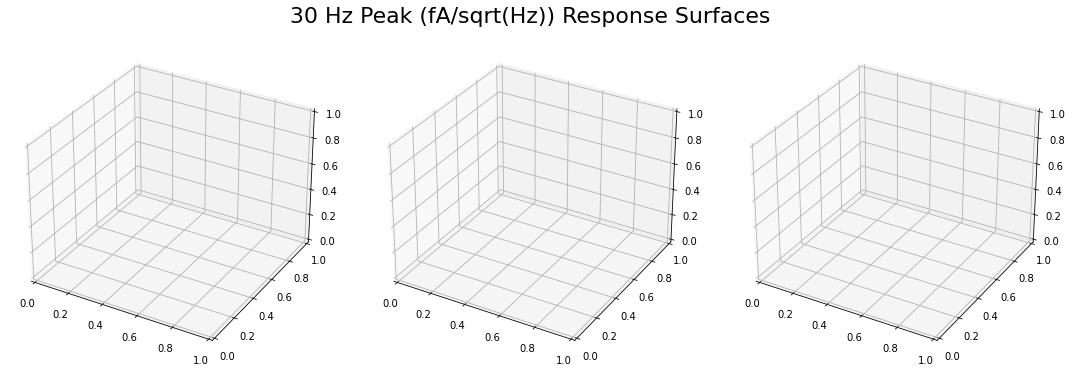

In [14]:
from scipy.optimize import curve_fit

# test function
def test_function(data, a, b, c):
    x = data[0]
    y = data[1]
    return a * (x**b) * (y**c)

def function(data, a, b, c, d, e):
    x = data[0]
    y = data[1]
    return a + b * x + c * y + d*x*y + e

def nonliner_function(data, a, b, c, d, e, f, g, h, k):
    x = data[0]
    y = data[1]
    return a + b * x + c * y + d*x*y + f*(x**2) + h*(y**2) + g*(x*y)**2 + e

def fit_data(fn, X, Y, Z):
    # get fit parameters from scipy curve fit
    parameters, covariance = curve_fit(fn, [X, Y], Z)

    # create surface function model
    # setup data points for calculating surface model
    model_x_data = np.linspace(min(X), max(X), 50)
    model_y_data = np.linspace(min(Y), max(Y), 50)
    # create coordinate arrays for vectorized evaluations
    X_fit, Y_fit = np.meshgrid(model_x_data, model_y_data)
    # calculate Z coordinate array
    Z_fit = fn(np.array([X_fit, Y_fit]), *parameters)

    return X_fit, Y_fit, Z_fit



cmap = "cool"
cmap = "viridis"
label_pad = 10
axis_font_size = 16
tick_font_size = 14

x_label = factor_A_label
y_label = factor_B_label
z_label = response_1_label
# z_label = 'Apparent Column Width (nm)'
c_label = response_2_label

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True, subplot_kw={'projection': '3d'})
plt.suptitle(z_label + " Response Surfaces", fontsize=22)

X = data[x_label]
Y = data[y_label]
Z = data[z_label]
S = np.full((len(X),), 100)
C = data[c_label]
ln_C = np.log(C)

fit = fit_data(function, X, Y, Z)
ax1.plot_surface(*fit, alpha=0.5)
scatter1 = ax1.scatter(X, Y, Z, s=S, c=ln_C, label = C, cmap=cmap, alpha=1.0)
# handles1, labels1 = scatter1.legend_elements(prop="colors")
# legend1 = ax1.legend(handles1, labels1, loc="lower right", title=c_label)
# ax1.set_title("Maximum CNTF Height Response", fontsize=18, pad=20)
ax1.view_init(15, 60)
ax1.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax1.set_xlabel(x_label, fontsize=axis_font_size, labelpad=label_pad)
ax1.set_ylabel(y_label, fontsize=axis_font_size, labelpad=label_pad)
ax1.set_zlabel(z_label, fontsize=axis_font_size)
ax1.invert_xaxis()
fig.colorbar(scatter1, label=response_2_label)

x_label2 = factor_A_label
y_label2 = factor_C_label
X2 = data[x_label2]
Y2 = data[y_label2]
fit2 = fit_data(function, X2, Y2, Z)
ax2.plot_surface(*fit2, alpha=0.5)
scatter2 = ax2.scatter(X2, Y2, Z, s=S,  c=ln_C, label = C, cmap=cmap, alpha=1.0)
# handles2, labels2 = scatter2.legend_elements(prop="colors")
# legend2 = ax2.legend(handles2, labels2, loc="lower right", title=c_label)
# ax2.set_title("Maximum CNTF Height Response", fontsize=18, pad=10)
ax2.view_init(15, 60)
ax2.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax2.set_xlabel(x_label2, fontsize=axis_font_size, labelpad=label_pad)
ax2.set_ylabel(y_label2, fontsize=axis_font_size, labelpad=label_pad)
ax2.set_zlabel(z_label, fontsize=axis_font_size)
ax2.invert_xaxis()

x_label3 = factor_A_label
y_label3 = factor_D_label
X3 = data[x_label3]
Y3 = data[y_label3]
fit3 = fit_data(function, X3, Y3, Z)
ax3.plot_surface(*fit3, alpha=0.5)
scatter3 = ax3.scatter(X3, Y3, Z, s=S,  c=ln_C, label = C, cmap=cmap, alpha=1.0)
# handles2, labels2 = scatter3.legend_elements(prop="colors")
# legend2 = ax3.legend(handles2, labels2, loc="lower right", title=c_label)
# ax3.set_title("Maximum CNTF Height Response", fontsize=18, pad=10)
ax3.view_init(15, 60)
ax3.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax3.set_xlabel(x_label3, fontsize=axis_font_size, labelpad=label_pad)
ax3.set_ylabel(y_label3, fontsize=axis_font_size, labelpad=label_pad)
ax3.set_zlabel(z_label, fontsize=axis_font_size)
ax3.invert_xaxis()

# handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")
# for i in range(len(X)): #plot each point + it's index as text above
#     ax.text(X[i]+0.5, Y[i]+0.5, Z[i], f'Flow: {C[i]}', size=16, zorder=1, color='k', weight='bold') 

plt.show()

# Compute effects of factors on response 

The main effect of A is calculated by subtracting the average responses at the low-level from the average responses at the high-level. For a $2^2$ design, 

the main effect of factor $A = \frac{1}{2n}[(ab+a)-(b+1)]$,

main effect of factor $B = \frac{1}{2n}[(ab+b)-(a+1)]$.

The interaction effect of factor AB is calculated by subtracting the average  responses when interactions are not present from the average interaction responses at the high-level. So, $AB = \frac{1}{2n}[(ab+1)-(a+b)]$

In [12]:
highs = data[[factor_A_label, factor_B_label, factor_C_label]].max()
lows = data[[factor_A_label, factor_B_label, factor_C_label]].min()

### Calculate the average high response for factor A

In [13]:
B_high_mask = data[factor_B_label] == highs[factor_B_label]
B_high_responses = data[B_high_mask][response_1_label] 
B_high_responses_mean = B_high_responses.mean()
B_high_responses_mean

2.125

### Calculate the average low response for factor A

In [14]:
B_low_mask = data[factor_B_label] == lows[factor_B_label]
B_low_responses = data[B_low_mask][response_1_label] 
B_low_responses_mean = B_low_responses.mean()
B_low_responses_mean

1.15

In [15]:
B_high_responses_mean - B_low_responses_mean

0.9750000000000001

## Calculate and plot the components of interaction effects

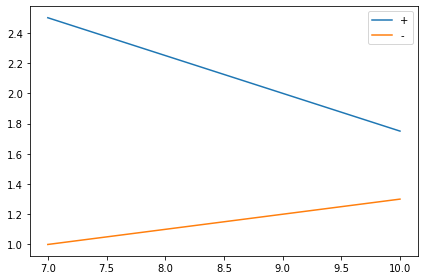

In [16]:
highA = data[factor_A_label].max()
lowA = data[factor_A_label].min()

maskHighAHighB = (data['A'] == 1) & (data['B'] == 1)
maskHighALowB = (data['A'] == 1) & (data['B'] == -1)
maskLowAHighB = (data['A'] == -1) & (data['B'] == 1)
maskLowALowB = (data['A'] == -1) & (data['B'] == -1)

y1 = data[maskHighAHighB][response_1_label].mean()
y2 = data[maskHighALowB][response_1_label].mean()
y3 = data[maskLowAHighB][response_1_label].mean()
y4 = data[maskLowALowB][response_1_label].mean()

plt.plot([lowA, highA], [y1,y3], label='+')
plt.plot([lowA, highA], [y2,y4], label='-')
plt.tight_layout()
plt.legend(loc='best')
plt.show()

### Generalize the code above for ease of use!

In [9]:
from scipy.optimize import curve_fit

# test function
def test_function(data, a, b, c):
    x = data[0]
    y = data[1]
    return a * (x**b) * (y**c)

def function(data, a, b, c, d, e):
    x = data[0]
    y = data[1]
    return a + b * x + c * y + d*x*y + e

def nonliner_function(data, a, b, c, d, e, f, g, h, k):
    x = data[0]
    y = data[1]
    return a + b * x + c * y + d*x*y + f*(x**2) + h*(y**2) + g*(x*y)**2 + e

def fit_data(fn, X, Y, Z):
    # get fit parameters from scipy curve fit
    parameters, covariance = curve_fit(fn, [X, Y], Z)

    # create surface function model
    # setup data points for calculating surface model
    model_x_data = np.linspace(min(X), max(X), 50)
    model_y_data = np.linspace(min(Y), max(Y), 50)
    # create coordinate arrays for vectorized evaluations
    X_fit, Y_fit = np.meshgrid(model_x_data, model_y_data)
    # calculate Z coordinate array
    Z_fit = fn(np.array([X_fit, Y_fit]), *parameters)

    return X_fit, Y_fit, Z_fit

In [10]:
def plot_3F_factorial_surface(data, response_label, factor_A_label, factor_B_label, factor_C_label):
    cmap = "cool"
    cmap = "viridis"
    label_pad = 10
    axis_font_size = 16
    tick_font_size = 14

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True, subplot_kw={'projection': '3d'})
    plt.suptitle(response_label + " Response Surfaces", fontsize=22)

    X = data[factor_A_label]
    Y = data[factor_B_label]
    Z = data[response_label]
    S = np.full((len(X),), 100)
    C = data[response_label]
    ln_C = np.log(C)

    fit = fit_data(function, X, Y, Z)
    ax1.plot_surface(*fit, alpha=0.5)
    ax1.scatter(X, Y, Z, s=S, c=ln_C, label = C, cmap=cmap, alpha=1.0)
    # handles1, labels1 = scatter1.legend_elements(prop="colors")
    # legend1 = ax1.legend(handles1, labels1, loc="lower right", title=c_label)
    # ax1.set_title("Maximum CNTF Height Response", fontsize=18, pad=20)
    ax1.view_init(15, 60)
    ax1.tick_params(axis='both', which='major', labelsize=tick_font_size)
    ax1.set_xlabel(factor_A_label, fontsize=axis_font_size, labelpad=label_pad)
    ax1.set_ylabel(factor_B_label, fontsize=axis_font_size, labelpad=label_pad)
    ax1.set_zlabel(response_label, fontsize=axis_font_size)
    ax1.invert_xaxis()

    X2 = data[factor_A_label]
    Y2 = data[factor_C_label]
    fit2 = fit_data(function, X2, Y2, Z)
    ax2.plot_surface(*fit2, alpha=0.5)
    ax2.scatter(X2, Y2, Z, s=S,  c=ln_C, label = C, cmap=cmap, alpha=1.0)
    # handles2, labels2 = scatter2.legend_elements(prop="colors")
    # legend2 = ax2.legend(handles2, labels2, loc="lower right", title=c_label)
    # ax2.set_title("Maximum CNTF Height Response", fontsize=18, pad=10)
    ax2.view_init(15, 60)
    ax2.tick_params(axis='both', which='major', labelsize=tick_font_size)
    ax2.set_xlabel(factor_A_label, fontsize=axis_font_size, labelpad=label_pad)
    ax2.set_ylabel(factor_C_label, fontsize=axis_font_size, labelpad=label_pad)
    ax2.set_zlabel(response_label, fontsize=axis_font_size)
    ax2.invert_xaxis()

    X3 = data[factor_B_label]
    Y3 = data[factor_C_label]
    fit3 = fit_data(function, X3, Y3, Z)
    ax3.plot_surface(*fit3, alpha=0.5)
    ax3.scatter(X3, Y3, Z, s=S,  c=ln_C, label = C, cmap=cmap, alpha=1.0)
    # handles2, labels2 = scatter3.legend_elements(prop="colors")
    # legend2 = ax3.legend(handles2, labels2, loc="lower right", title=c_label)
    # ax3.set_title("Maximum CNTF Height Response", fontsize=18, pad=10)
    ax3.view_init(15, 60)
    ax3.tick_params(axis='both', which='major', labelsize=tick_font_size)
    ax3.set_xlabel(factor_B_label, fontsize=axis_font_size, labelpad=label_pad)
    ax3.set_ylabel(factor_C_label, fontsize=axis_font_size, labelpad=label_pad)
    ax3.set_zlabel(response_label, fontsize=axis_font_size)
    ax3.invert_xaxis()

    # handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    # legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")
    # for i in range(len(X)): #plot each point + it's index as text above
    #     ax.text(X[i]+0.5, Y[i]+0.5, Z[i], f'Flow: {C[i]}', size=16, zorder=1, color='k', weight='bold') 

    plt.show()

In [11]:
def calc_main_effect(data, factor, response):
    high = data[factor].max()
    low = data[factor].min()

    means = {}
    for level in [high, low]:
        factor_level_mask = data[factor] == level
        level_response_mean = data[factor_level_mask][response].mean()
        means[level] = level_response_mean

    return means[high] - means[low]

In [12]:
def calc_interaction_effect(data, factor1, factor2, response):
    high1 = data[factor1].max()
    low1 = data[factor1].min()
    high2 = data[factor2].max()
    low2 = data[factor2].min()

    means = {}
    for level2 in [high2, low2]:
        factor2_level_mask = data[factor2] == level2
        factor2_level_responses = data[factor2_level_mask][response]

        factor2_level_factor1 = data[factor2_level_mask][factor1]
        conditions = [(factor2_level_factor1 == high1),(factor2_level_factor1 == low1)]
        choices = [1, -1]
        factor_signs = np.select(conditions, choices)
        factor2_responses_factor1_signs = factor2_level_responses * factor_signs
        factor1_factor2_responses_mean = factor2_responses_factor1_signs.mean()
        means[level2] = factor1_factor2_responses_mean

    return means[high2] - means[low2]    

In [13]:
def calc_3Factor_effects(data, response_label, factor_A_label, factor_B_label, factor_C_label):
    effect_A = calc_main_effect(data, factor_A_label, response_label)
    effect_B = calc_main_effect(data, factor_B_label, response_label)
    effect_C = calc_main_effect(data, factor_C_label, response_label)
    effect_AB = calc_interaction_effect(data, factor_A_label, factor_B_label, response_label)
    effect_AC = calc_interaction_effect(data, factor_A_label, factor_C_label, response_label)
    effect_BC = calc_interaction_effect(data, factor_B_label, factor_C_label, response_label)
    effects = np.array([effect_A, effect_B, effect_C, effect_AB, effect_AC, effect_BC])
    return effects

In [14]:
def main_effect_plot_3F(data, response_label, factor_A_label, factor_B_label, factor_C_label):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))
    y = data[response_label]
    factors = [factor_A_label, factor_B_label, factor_C_label]
    factor_letters = ['A','B','C']
    axs = [ax1, ax2, ax3]
    for i in range(len(axs)):
        ax = axs[i]
        factor = factors[i]
        x = data[factor]
        ax.scatter(x, y, s=100)
        # ax.set_ylim(ymin=0, ymax=200)
        ax.set_xlabel(factor)
        ax.set_ylabel(response_label)
        ax.set_title(f'Factor {factor_letters[i]}', fontsize=16, fontweight='bold', loc='center')
    
    fig.tight_layout()
    plt.show()

In [30]:
def plot_response_surfaces(data, response_label, factor_labels):
    cmap = "cool"
    cmap = "viridis"
    label_pad = 10
    axis_font_size = 12
    tick_font_size = 14


    n = len(factor_labels)
    fig_scale = 4
    fig, axs = plt.subplots(n, n, figsize=(fig_scale*n,fig_scale*n), constrained_layout=True, subplot_kw={'projection': '3d'})
    plt.suptitle(response_label + " Response Surfaces", fontsize=22)


    # build a rectangle in axes coords
    left, width = -0.33, 1.66
    bottom, height = -0.2, 1.4
    right = left + width
    top = bottom + height

    Z = data[response_label]
    C = data[response_label]
    ln_C = np.log(C)
    S = np.full((len(Z),), 100)

    for i, row in enumerate(axs):
        for j, ax in enumerate(row):
            factor_A_label = factor_labels[i]
            factor_B_label = factor_labels[j]

            X = data[factor_A_label]
            Y = data[factor_B_label]
            fit = fit_data(function, X, Y, Z)
            ax.plot_surface(*fit, alpha=0.5)
            ax.scatter(X, Y, Z, s=S, c=ln_C, label = C, cmap=cmap, alpha=1.0)
            # handles1, labels1 = scatter1.legend_elements(prop="colors")
            # legend1 = ax.legend(handles1, labels1, loc="lower right", title=c_label)
            # ax.set_title("Maximum CNTF Height Response", fontsize=18, pad=20)
            ax.view_init(15, 60)
            ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
            ax.set_xlabel(factor_A_label, fontsize=axis_font_size, labelpad=label_pad)
            ax.set_ylabel(factor_B_label, fontsize=axis_font_size, labelpad=label_pad)
            ax.set_zlabel(response_label, fontsize=axis_font_size)
            ax.invert_xaxis()

            # handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
            # legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")
            # for i in range(len(X)): #plot each point + it's index as text above
            #     ax.text(X[i]+0.5, Y[i]+0.5, Z[i], f'Flow: {C[i]}', size=16, zorder=1, color='k', weight='bold') 

    plt.show()

In [16]:
import itertools

def calc_effects(data, response_label, factor_labels):
    main_effects = [calc_main_effect(data, factor_label, response_label) for factor_label in factor_labels]
    factor_pairs = itertools.combinations(factor_labels, 2)
    interaction_effects = []

    for factor_label1, factor_label2 in factor_pairs:
            interaction_effect = calc_interaction_effect(data, factor_label1, factor_label2, response_label)
            interaction_effects.append(interaction_effect)        
    
    effects = main_effects + interaction_effects
    return effects

In [17]:
def plot_main_effects(data, response_label, factor_labels):
    n = len(factor_labels)
    fig, axs = plt.subplots(1, n, figsize=(5*n,5))
    y = data[response_label]
    factor_letters = ['A','B','C']

    for i in range(len(axs)):
        ax = axs[i]
        factor = factor_labels[i]
        x = data[factor]
        ax.scatter(x, y, s=100)
        # ax.set_ylim(ymin=0, ymax=200)
        ax.set_xlabel(factor)
        ax.set_ylabel(response_label)
        ax.set_title(f'Factor {factor}', fontsize=16, fontweight='bold', loc='center')
    
    fig.tight_layout()
    plt.show()

In [18]:
def interaction_plot(data, response, factor1, factor2):
    high1 = data[factor1].max()
    low1 = data[factor1].min()
    high2 = data[factor2].max()
    low2 = data[factor2].min()

    maskHighAHighB = (data[factor1] == high1) & (data[factor2] == high2)
    maskHighALowB = (data[factor1] == high1) & (data[factor2] == low2)
    maskLowAHighB = (data[factor1] == low1) & (data[factor2] == high2)
    maskLowALowB = (data[factor1] == low1) & (data[factor2] == low2)

    y1 = data[maskLowAHighB][response].mean() 
    y2 = data[maskLowALowB][response].mean()
    y3 = data[maskHighAHighB][response].mean()
    y4 = data[maskHighALowB][response].mean()

    plt.title(f'Interaction between {factor1} and {factor2}')
    plt.plot([low1, high1], [y1,y3], label=f'+ {factor2}')
    plt.plot([low1, high1], [y2,y4], label=f'- {factor2}')
    plt.xlabel(f'{factor1}')
    plt.ylabel(response)

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

In [19]:
def plot_interaction_effects(data, response_label, factor_labels):
    n = math.factorial(len(factor_labels))
    fig, axs = plt.subplots(n//2, n//2, figsize=(5*n,5))

    for i, row in enumerate(axs):
        for j, ax in enumerate(axs):
            if i != j:
                factor1 = factor_labels[i]
                factor2 = factor_labels[j]


                high1 = data[factor1].max()
                low1 = data[factor1].min()
                high2 = data[factor2].max()
                low2 = data[factor2].min()

                maskHighAHighB = (data[factor1] == high1) & (data[factor2] == high2)
                maskHighALowB = (data[factor1] == high1) & (data[factor2] == low2)
                maskLowAHighB = (data[factor1] == low1) & (data[factor2] == high2)
                maskLowALowB = (data[factor1] == low1) & (data[factor2] == low2)

                y1 = data[maskLowAHighB][response_label].mean() 
                y2 = data[maskLowALowB][response_label].mean()
                y3 = data[maskHighAHighB][response_label].mean()
                y4 = data[maskHighALowB][response_label].mean()

                ax.plot([low1, high1], [y1,y3], label=f'+ {factor2}')
                ax.plot([low1, high1], [y2,y4], label=f'- {factor2}')
                ax.xlabel(f'{factor1}')
                ax.ylabel(response_label)
                ax.set_title(f'Interaction between {factor1} and {factor2}')

                plt.tight_layout()
                plt.legend(loc='best')

    fig.tight_layout()
    plt.show()

In [31]:
def linear(x, m, b):
    return m*x + b

fontsize = 16
def plot_effect_grid(data, response_label, factor_labels):
    n = len(factor_labels)
    fig_scale = 4
    fig, axs = plt.subplots(n, n, figsize=(fig_scale*n,fig_scale*n))
    y = data[response_label]
    C = data[response_label]

    # build a rectangle in axes coords
    left, width = -0.33, 1.66
    bottom, height = -0.2, 1.4
    right = left + width
    top = bottom + height

    for i, row in enumerate(axs):
        for j, ax in enumerate(row):
            factor = factor_labels[i]

            if i == j:
                # main effects
                x = data[factor]

                # linear fit
                param, param_cov = curve_fit(linear, x, y)
                # ans stores the new y-data according to
                # the coefficients given by curve-fit() function
                ans = param[0]*x + param[1]
                # print(param[0], param[1])

                # z = np.polyfit(x, y1, 1)
                # p = np.poly1d(z)
                # print(z)

                scatter = ax.scatter(x, y, s=100, c=C)
                ax.plot(x, ans, linestyle='dashed', color ='black', label='linear fit')
                # ax.text(1.0, 0.2, f'Intercept = {param[0]:.2}, Slope = {param[1]:.2}', fontsize = 11)

                # ax.set_ylim(ymin=0, ymax=200)
                ax.set_xlabel(factor)
                ax.set_ylabel(response_label)
                ax.set_title(f'{factor}')
                ax.legend(loc='best')
                # fig.colorbar(scatter, label=response_2_label)

                if i == 0:
                    ax.text(0.5*(left+right), top, factor,
                            horizontalalignment='center',
                            verticalalignment='center',
                            transform=ax.transAxes,
                            fontsize=fontsize, 
                            fontweight='bold')
                    ax.text(left, 0.5*(bottom+top), factor,
                            horizontalalignment='center',
                            verticalalignment='center',
                            rotation=90,
                            transform=ax.transAxes,
                            fontsize=fontsize, 
                            fontweight='bold')

            else:
                # interaction effects
                factor1 = factor
                factor2 = factor_labels[j]

                high1 = data[factor1].max()
                low1 = data[factor1].min()
                high2 = data[factor2].max()
                low2 = data[factor2].min()

                maskHighAHighB = (data[factor1] == high1) & (data[factor2] == high2)
                maskHighALowB = (data[factor1] == high1) & (data[factor2] == low2)
                maskLowAHighB = (data[factor1] == low1) & (data[factor2] == high2)
                maskLowALowB = (data[factor1] == low1) & (data[factor2] == low2)

                y1 = data[maskLowAHighB][response_label].mean() 
                y2 = data[maskLowALowB][response_label].mean()
                y3 = data[maskHighAHighB][response_label].mean()
                y4 = data[maskHighALowB][response_label].mean()

                ax.plot([low1, high1], [y1,y3], label=f'+ {factor2}')
                ax.plot([low1, high1], [y2,y4], label=f'- {factor2}')
                ax.set_xlabel(f'{factor1}')
                ax.set_ylabel(response_label)
                ax.set_title(f'{factor1}:{factor2}')
                ax.legend(loc='best')

                if i == 0:
                    ax.text(0.5*(left+right), top, factor2,
                            horizontalalignment='center',
                            verticalalignment='center',
                            transform=ax.transAxes,
                            fontsize=fontsize, 
                            fontweight='bold')
                if j == 0:
                    ax.text(left, 0.5*(bottom+top), factor,
                            horizontalalignment='center',
                            verticalalignment='center',
                            rotation=90,
                            transform=ax.transAxes,
                            fontsize=fontsize, 
                            fontweight='bold')

    fig.tight_layout()
    plt.show()

In [ ]:
n = 2
fig, axs = plt.subplots(n, n, figsize=(5*n,5*n))
x = [1, 2, 3]
y = np.array([1,2,3])

for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ax.scatter(x,y)   
        ax.set_ylabel("response_label")  
        ax.set_title('label')

In [21]:
from matplotlib.ticker import PercentFormatter

def Pareto_plot(effects, factor_labels, xlabel, ylabel):
    colors = []
    signs = []
    for effect in effects:
        if effect < 0:
            colors.append('gray')
            signs.append(-1)
        else:
            colors.append('royalblue')
            signs.append(1)

    effects_df = pd.DataFrame({
                    'factors': factor_labels,
                    'effects': np.abs(effects),
                    'signs': signs,
                    'colors': colors
                })

    effects_df_sorted = effects_df.sort_values('effects', ascending=False)
    x = effects_df_sorted['factors'].values
    y = effects_df_sorted['effects'].values
    c = effects_df_sorted['colors'].values
    s = effects_df_sorted['signs'].values
    weights = y / y.sum()
    cumsum = weights.cumsum()    

    fig, ax1 = plt.subplots()
    legend_labels = ['Positive Sign','Negative Sign']
    handles = [plt.Rectangle((0,0), 1,1, color='royalblue'), plt.Rectangle((0,0), 1,1, color='gray')]
    plt.legend(handles, legend_labels, loc='center right')

    ax1.bar(x, y, color = c)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    ax2 = ax1.twinx()
    ax2.plot(x, cumsum, '-ro', alpha=0.5)
    ax2.set_ylabel('', color='r')
    ax2.tick_params('y', colors='r')

    vals = ax2.get_yticks()
    ax2.yaxis.set_major_formatter(PercentFormatter())

    # hide y-labels on right side
    show_pct_y = False
    if not show_pct_y:
        ax2.set_yticks([])

    pct_format='{0:.0%}'
    formatted_weights = [pct_format.format(x) for x in cumsum]
    for i, txt in enumerate(formatted_weights):
        ax2.annotate(txt, (x[i], cumsum[i]), fontweight='heavy')    

    title = f'Pareto plot of Main and Interaction Effects on Response'
    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

## Lets use these to investigate the factorial data 

c:\Users\Darian\miniconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


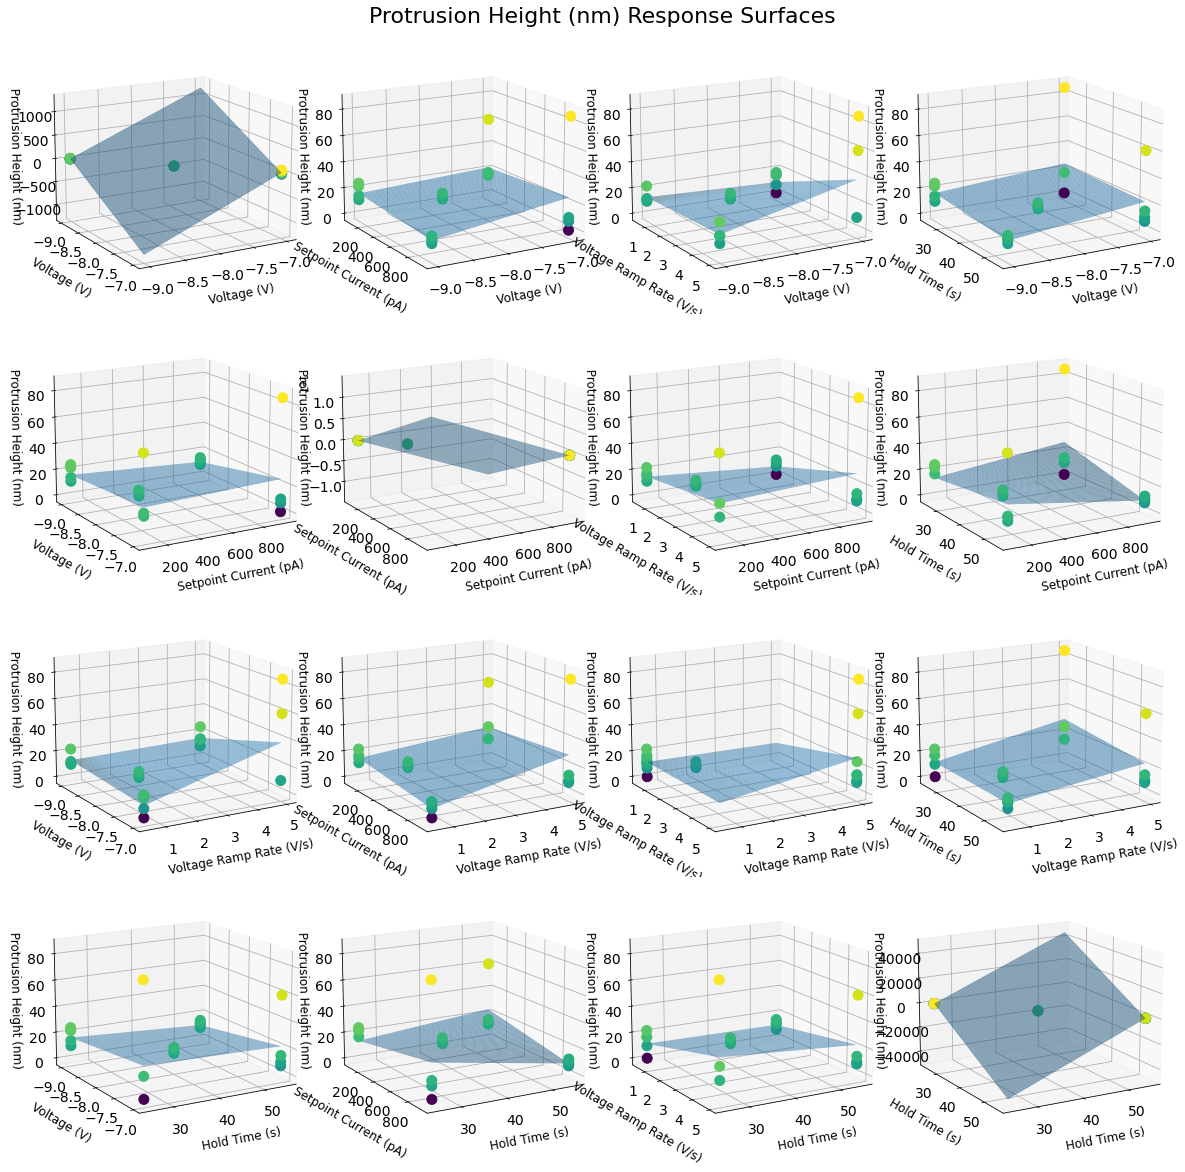

In [56]:
plot_response_surfaces(data, response_3_label, factor_labels)

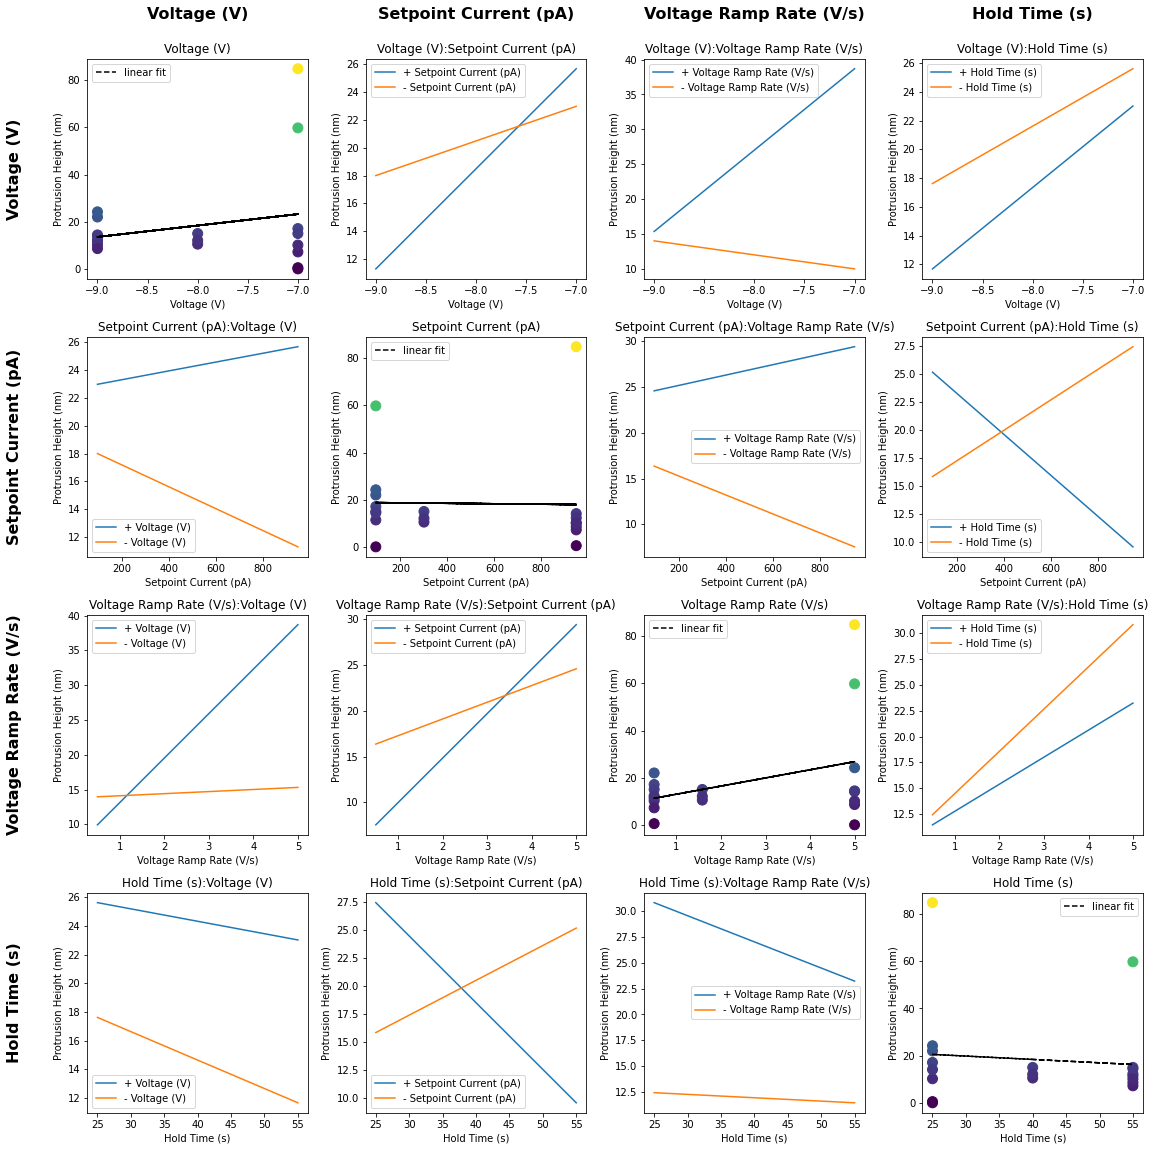

In [57]:
plot_effect_grid(data, response_3_label, factor_labels)

10 10


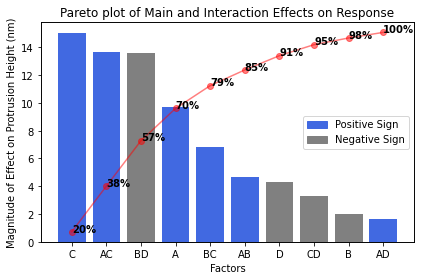

In [58]:
effects = calc_effects(data, response_3_label, factor_labels)
xlabel = 'Factors'
ylabel = f'Magnitude of Effect on {response_3_label}'
# factor_letters = ['A', 'B', 'C', 'D', 'AB', 'AC', 'AD', 'BA', 'BC', 'BD', 'CA', 'CB', 'CD', 'DA', 'DB', 'DC']
# factor_letters = ['A', 'B', 'C', 'AB', 'AC', 'BC']
factor_letters = ['A', 'B', 'C', 'D', 'AB', 'AC', 'AD', 'BC', 'BD', 'CD']
print(len(effects), len(factor_letters))
Pareto_plot(effects, factor_letters, xlabel, ylabel)

In [ ]:
plot_interaction_effects(data, response_1_label, factor_labels)

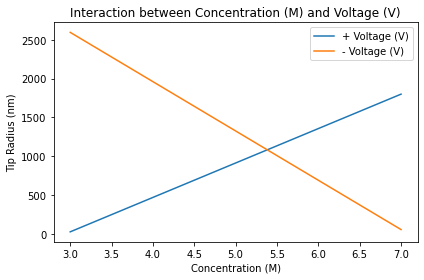

In [32]:
interaction_plot(data, response_1_label, factor_A_label, factor_B_label)

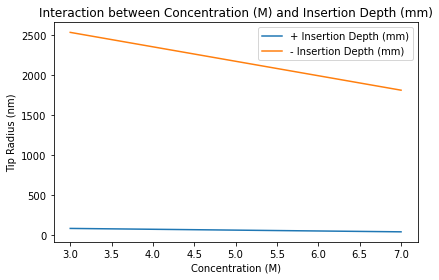

In [33]:
interaction_plot(data, response_1_label, factor_A_label, factor_C_label)

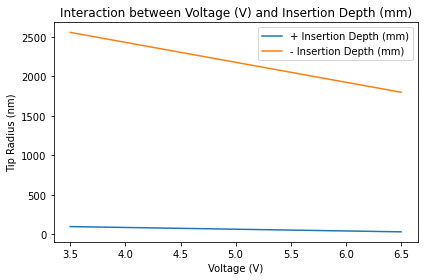

In [34]:
interaction_plot(data, response_1_label, factor_B_label, factor_C_label)

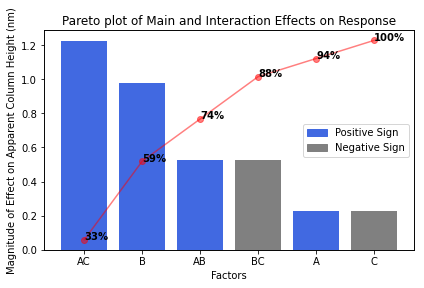

In [30]:
effects = calc_3Factor_effects(data, response_1_label, *factor_labels)
xlabel = 'Factors'
ylabel = f'Magnitude of Effect on {response_1_label}'
Pareto_plot(effects, factor_letters, xlabel, ylabel)

## Interperating these plots is another matter not covered here!